In [ ]:
# !python -m pip install more-itertools

In [ ]:
# !pip install pybktree

In [ ]:
# ! wget https://raw.githubusercontent.com/dwyl/english-words/master/words_dictionary.json

In [ ]:
# ! wget https://raw.githubusercontent.com/JorgeDuenasLerin/diccionario-espanol-txt/master/0_palabras_todas.txt

# ¡Para continuar parece que hay que mergear con el módulo de Hough Transform!

## Condiciones

- **Los nombres en minúscula, los tipos de datos (INT, VARCHAR, ETC) en mayúscula.**
- **El nombre del atributo no puede contener espacios en blanco y tampoco camelCase.** Por ahora es solo snake_case.
- **Las FK deben seguir el formato {nombre_tabla}_id o tener el mismo nombre que la PK de la tabla con la que se relacionan.** Las relaciones las sabemos con el módulo de Hough Transform.
- **Si es muchos a muchos, deberiamos chequear si tiene solo dos conexiones de tipo many, o que tenga si o si el formato {tabla1}x{tabla2}.**
- **Todas las PKs tienen que tener el formato {nombre_atributo}_id**. Todas las que cumplen con ese formato y no sean FKs serán tomadas como PKs.

## TODO
- Cuando hay una mayuscula en el medio que no puede haber en el nombre del atributo, se rompe. Mientras haya una minuscula o algo adelante debería ponerse bien. Lo que sí, eso daría a entender que es una letra que está mal asi que quizás conviene avisar.
- **Evaluar OCR** https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510

In [ ]:
# !pip install "paddleocr>=2.0.1"
# !python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
import sys
sys.path.append("../")

from src.line_detection.hough import get_tablas

In [2]:
import re
import os
import cv2
import json
import jellyfish
import pybktree
import numpy as np
import itertools
from more_itertools import subslices

from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
from IPython.display import display

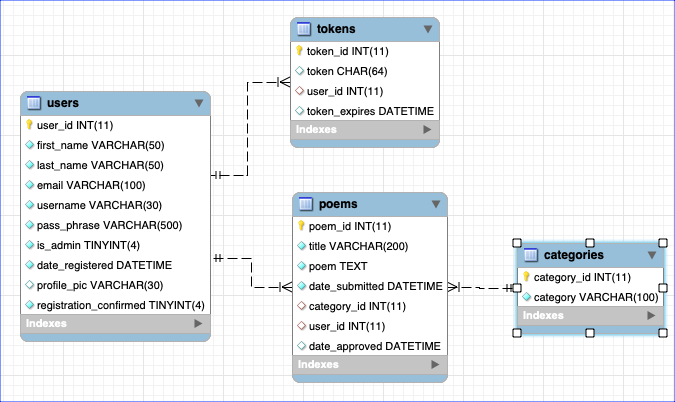

In [3]:
IMG_PATH = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-5.png'
IMG_BASENAME = os.path.basename(IMG_PATH)
tablas, cardinalidades = get_tablas(IMG_BASENAME)
img = Image.open(IMG_PATH)
img

In [4]:
ocr = PaddleOCR(use_angle_cls=False, lang='en', show_log=False, 
                det_algorithm_dir="/home/nacho/TFI-Cazcarra/ocr/db/", 
                #rec_char_dict_path="../icr15_dict_original.txt", 
                rec_algorithm_dir="/home/nacho/TFI-Cazcarra/ocr/svtr/", det_db_score_mode="slow") 

In [5]:
with open("./words_dictionary.json", "rb") as f:
    english_dict = f.read()
english_words = json.loads(english_dict).keys()

with open("./0_palabras_todas.txt", "rb") as f:
    spanish_words = f.readlines()
spanish_words = [s.decode('utf8').replace("\n", "") for s in spanish_words]

In [6]:
class Item():
    def __init__(self, value):
        self.value = value

def item_distance(x, y):
    return jellyfish.levenshtein_distance(x.value, y.value)

english_tree = pybktree.BKTree(item_distance, [Item(w) for w in english_words])
spanish_tree = pybktree.BKTree(item_distance, [Item(w) for w in spanish_words])

In [7]:
def reescale(img, scale_percent=150):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    return img

In [8]:
img = Image.open(IMG_PATH)
img = np.array(img)

images = []
results = []

for t in tablas:
    tabla_cropped = img[t[1]:t[3], t[0]:t[2]]
    tabla_cropped = reescale(tabla_cropped)
    if len(tabla_cropped.shape) == 3 and tabla_cropped.shape[-1] > 3:
        tabla_cropped = tabla_cropped[:,:,:3]
    result = ocr.ocr(tabla_cropped, cls=False)
    
    images.append(Image.fromarray(tabla_cropped))
    results.append(result[0])

In [9]:
def get_allowed_dtypes(db_name):
    if db_name.lower() == "mysql":
        STRING_TYPES = ["CHAR", "VARCHAR", "BINARY", "VARBINARY", "TINYBLOB", "TINYTEXT", "TEXT", "BLOB", 
                        "MEDIUMTEXT", "MEDIUMBLOB", "LONGTEXT", "LONGBLOB", "ENUM", "SET"]
        NUMERIC_TYPES = ["BIT", "TINYINT", "BOOLEAN", "SMALLINT", "MEDIUMINT", "INT", "INTEGER", "BIGINT", 
                         "FLOAT", "DOUBLE", "DOUBLE PRECISION", "DECIMAL", "DEC"]
        DATETIME_TYPES = ["DATE", "DATETIME", "TIMESTAMP", "TIME", "YEAR"]
        SPATIAL_TYPES = ["GEOMETRY", "POINT", "LINESTRING", "POLYGON"]
        return (STRING_TYPES + NUMERIC_TYPES + DATETIME_TYPES + SPATIAL_TYPES)
    else:
        print(f"'{db_name}' not supported yet!")
        return []

In [10]:
def get_dtype_number(text):
    if "," not in text:
        return re.findall("\d+", text) # Devuelve solo numeros juntos.
    else:
        return re.findall("\d+\,\d+", text) # Devuelve numeros con coma para dtypes como DECIMAL(5,2)

In [11]:
def sep_text(text):
    '''
    Separa las palabras pegadas a una mayúscula como city_idVARCHAR(45). O sea, cuando no se detecta el espacio.
    '''
    return re.findall("[A-Z]+[^A-Z]*|[^A-Z]+",text)

In [12]:
def get_dtype(possible_dtype, dtypes):
    '''
    Devuelve el dtype que más se le parece al string. Para hacerlo más rapido podría usar un bktree.
    '''
    dict_dtypes = {k: jellyfish.jaro_distance(possible_dtype, k) for k in dtypes}
    return (max(dict_dtypes, key=dict_dtypes.get), max(dict_dtypes.values()))

In [ ]:
## Ejemplo "hola_c omo e st as"
## ["hola", "c omo e st as"]
## Para "c omo e st as" habría que generar todas las combinaciones


## Generas combinaciones desde 0 a len(str). Cuando encontras la palabra correcta para un subset, 
##    ahi recien las eliminas del string normal.
## o mejor aun, haces todas pero todas las combinaciones

## Agarras todas las combinaciones y le calculas el jaccard distance a todas dentro de cada subset.
## Si tienen la misma distancia, toma la combinación mas grande.

## En TODOS los casos donde se dude, se avisa


## EJEMPLOS A PENSAR:
# "pic ture" -> picture
# "table_nam e" -> table_name
# "pay ment_data" -> payment_data
# "pay ments_data" -> payments_data
# "pay men ls_data" -> payments_data
# "word_to fix" -> word_to_fix
# "n ame s" -> names
# "ias t" -> last

In [13]:
def chunks(items, cutpoints):
    return [items[i:j] for i,j in zip([0] + cutpoints, cutpoints + [len(items)])]

def generate_chunks(items, n):
    indices = range(1,len(items))
    return [chunks(items,list(cutpoints)) for cutpoints in itertools.combinations(indices,n-1)]

In [14]:
def get_average_score(comb, slices_dict):
    scores = []
    word = ""
    for c in comb:
        dict_c = slices_dict[c]
        if dict_c:
            max_key_score = max(dict_c, key=dict_c.get)
            max_score = dict_c[max_key_score]
        else:
            max_key_score = ""
            max_score = 0
        scores.append(max_score)
        word += max_key_score + "_"
    return word[:-1], sum(scores)/len(scores), len(comb)

In [15]:
def get_best_performing_sequence(word, slices_dict):
    all_combs = []
    for i in range(len(word)):
        all_combs += generate_chunks(word, i+1)
    all_combs = [[el.replace(" ", "") for el in l if not el.isspace()] for l in all_combs]
    all_combs.sort()
    all_combs = [l for l in list(k for k,_ in itertools.groupby(all_combs)) if all(el in slices_dict.keys() for el in l)]
    
    combs_dict = {}
    for comb in all_combs:
        word, avg_score, comb_len = get_average_score(comb, slices_dict)
        combs_dict[word] = (avg_score, comb_len)
        
    max_key = -1
    min_length = 99999
    max_score = 0

    for k,v in combs_dict.items():
        if v[0] >= max_score and v[1] < min_length:
            max_key = k
            max_score = v[0]
            min_length = v[1]
        
    return max_key

In [16]:
def get_dist_map(key, neighbors, top_n=5):
    dist_map = {n[1]: round(jellyfish.jaro_distance(key, n[1]), 2) for n in neighbors}
    sorted_topn = sorted(dist_map, key=dist_map.get, reverse=True)[:top_n]
    return {k:v for k,v in dist_map.items() if k in sorted_topn}


def top_n_dist_map(tree, slice_key, tolerance, top_n):
    slice_value = tree.find(Item(slice_key), tolerance)
    if slice_value:
        slice_value = [(res[0], res[1].value) for res in slice_value]
    return get_dist_map(key=slice_key, neighbors=slice_value, top_n=top_n)


def get_slices_dict(tree, slices, tolerance=1, top_n=5):
    slices_dict = {}
    for slice_ in slices:
        slice_key = "".join(slice_)
        slice_value = top_n_dist_map(tree, slice_key, tolerance, top_n)
        slices_dict[slice_key] = slice_value
    return slices_dict


def get_tree(mode):
    if mode == "english":
        tree = english_tree
    else:
        tree = spanish_tree
    return tree
        
        
def sanitize_words(splitted_attribute, mode="english"):
    '''
    Sanitizes every word of the attribute.
    '''
    tree = get_tree(mode)
    TOLERANCE = 1
    
    sanitized = []
    for word in splitted_attribute:
        word = word.strip()
        if " " in word:
            word_to_fix = word.split(" ")
            slices = list(subslices(word_to_fix))
            slices = ["".join(slice_).replace(" ", "") for slice_ in slices if slice_]
            slices = list(set(slices))
            slices_dict = get_slices_dict(tree, slices)
            longest_key = max(slices_dict.keys(), key=len) # Agarramos la secuencia más larga.
            longest_key_dict = slices_dict[longest_key] # Top N para esa secuencia.
            # Hay que dar por hecho que no hay typos, solo problemas con los espacios.
            if longest_key_dict and max(longest_key_dict.values()) == 1:
                longest_key_max_score = max(longest_key_dict, key=longest_key_dict.get)
                fixed_word = longest_key_max_score
            else:
                # Me tengo la secuencia en partes cuya suma de scores sea la mayor.
                fixed_word = get_best_performing_sequence(word, slices_dict)
            sanitized.append(fixed_word)
        else:
            sanitized.append(word) # Dejar así nomás; no suele haber typos y la podes cagar facilmente.
    return "_".join(sanitized)

In [17]:
# El problema es si se confunde una L por una | o cosas así. Status: deprecated.
def clean_attribute(attribute):
    '''
    Removes from str everything that's not a digit, underscore, dollar signs & characters (upper or lower).
    '''
    return re.sub("[^0-9a-zA-Z$_]+", "", attribute)


def get_clean_attribute(attribute):
    '''
    Debería ser algo así:
    - Separa por underscore porque espacios no deberia haber.
    - Lo que haya quedado junto y tenga espacios en blanco, lo probamos con y sin y nos quedamos con la palabra de
    ambas divisiones que tenga menor tolerancia.
    - Si hay que juntar juntamos, y si no separamos.
    - Reemplazamos los espacios por underscore y devolvemos.
    '''
    attribute = attribute.strip()
    if " " in attribute:
        splitted_attribute = attribute.split("_")
        attribute = sanitize_words(splitted_attribute)
#     else: # No vale la pena... deberia estar limpio.
#         attribute = clean_attribute(attribute)
    
    return attribute.replace("|","l").replace("I","l")

In [22]:
def get_valid_table_att(text_list):
    flag = False
    valid = ""
    i = -1
    while not flag and i < len(text_list)-1:
        i += 1
        if not text_list[i].isalpha() and not valid:
            continue
        if text_list[i].isupper() and not valid:
            valid += text_list[i]
        elif text_list[i].islower() or text_list[i].isspace() or text_list[i].isdigit() or text_list[i] in ["_","$"]:
            valid += text_list[i]
        else:
            flag = True
    return valid, i
    
def delim_attribute(text_list): 
    attribute, i = get_valid_table_att(text_list)
    dtype = "".join(text_list[i:])
    return attribute, dtype

In [19]:
def separate(text, db_name="mysql"):
    text_list = sep_text(text)
    text_list = " ".join(text_list)
    attribute, dtype = delim_attribute(text_list)
    attribute = get_clean_attribute(attribute)
    dtype_number = get_dtype_number(dtype)
    dtype = dtype.replace("(", "").replace(")","")
    dtype, _ = get_dtype(dtype, dtypes=get_allowed_dtypes(db_name))
    if dtype_number:
        dtype += f"({dtype_number[0]})"
        
    return attribute, dtype

In [20]:
def clean_texts(texts):
    if "Indexes" in texts:
        # Todo lo que venga después de Indexes está mal o pertenece a otra cosa.
        indexes_idx = texts.index("Indexes")
        texts = texts[:indexes_idx]
        
    table_name, _ = get_valid_table_att(texts[0]) # Para limpiarlo por si tiene espacios o simbolos.
    
    attributes = {} # K=name, V=type
    for t in texts[1:]:
        attribute, dtype = separate(t, db_name="mysql")
        attributes[attribute.strip()] = dtype
            
    return table_name, attributes





['users', 'user_id INT(11)', 'first_name VARCHAR(50)', 'last_name VARCHAR(50)', 'email VARCHAR(100)', 'username VARCHAR(30)', 'pass_phrase VARCHAR(500)', 'is_admin TINYINT(4)', 'date_registered DATETIME', 'profile_pic VARCHAR(30)', 'registration_confirmed TINYINT(4)', 'Indexes']
users {'user_id': 'INT(11)', 'first_name': 'VARCHAR(50)', 'last_name': 'VARCHAR(50)', 'email': 'VARCHAR(100)', 'username': 'VARCHAR(30)', 'pass_phrase': 'VARCHAR(500)', 'is_admin': 'TINYINT(4)', 'date_registered': 'DATETIME', 'profile_pic': 'VARCHAR(30)', 'registration_confirmed': 'TINYINT(4)'}


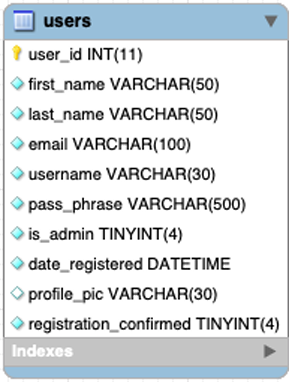





['poems', '? poem_id INT(11)', 'title VARCHAR(200)', 'poem TEXT', 'date_submitted DATETIME', 'category_id INT(11)', '>user_id INT(11)', 'date_approved DATETIME', 'Indexes']
poems {'poem_id': 'INT(11)', 'title': 'VARCHAR(200)', 'poem': 'TEXT', 'date_submitted': 'DATETIME', 'category_id': 'INT(11)', 'user_id': 'INT(11)', 'date_approved': 'DATETIME'}


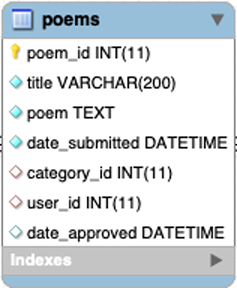





['tokens', 'token_id INT(11)', 'token CHAR(64)', 'user_id INT(11)', 'token_expires DATETIME', 'Indexes']
tokens {'token_id': 'INT(11)', 'token': 'CHAR(64)', 'user_id': 'INT(11)', 'token_expires': 'DATETIME'}


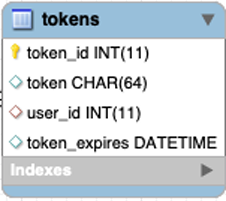





['categories', 'category_id INT(11)', 'category VARCHAR(100', 'Indexes']
categories {'category_id': 'INT(11)', 'category': 'VARCHAR(100)'}


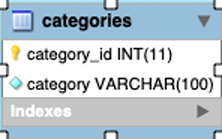

In [23]:
all_tables = {}

for i, r in zip(images, results):
    boxes = [line[0] for line in r]
    txts = [line[1][0].strip() for line in r]
    scores = [line[1][1] for line in r]
    print("\n\n\n")
    print(txts)
    table, dict_attributes = clean_texts(txts)
    all_tables[table] = dict_attributes
    
    print(table, dict_attributes)
    display(i)

In [34]:
list(itertools.permutations(all_tables.keys(), 2))

[('users', 'poems'),
 ('users', 'tokens'),
 ('users', 'categories'),
 ('poems', 'users'),
 ('poems', 'tokens'),
 ('poems', 'categories'),
 ('tokens', 'users'),
 ('tokens', 'poems'),
 ('tokens', 'categories'),
 ('categories', 'users'),
 ('categories', 'poems'),
 ('categories', 'tokens')]

In [24]:
def is_many_to_many(table_name, dict_attributes, table_names):
    '''
    Si el nombre de la tabla es {tabla}x{tabla}, entonces es many to many.
    O también deberia ser si simplemente tiene dos simbolos de many pegados. Esa es mejor mepa.
    Pero también tiene que pasar que se cumpla lo del nombre, porque no es exclusivo..
    '''
    for comb in list(itertools.permutations(table_names, 2)):
        if table_name.lower() == comb[0].lower()+"x"+comb[1].lower():
            return True
    return False

In [25]:
def get_primary_keys(dict_attributes, foreign_keys):
    '''
    Todos los atributos que no sean FK y tengan el formato {atributo}_id, son PK.
    '''
    return [k for k in dict_attributes.keys() if k not in foreign_keys and k[-3:]=="_id"]

In [26]:
def get_foreign_keys(dict_attributes, relationships_info):
    '''
    Acá primero hay que chequear, según el numero de relaciones, a cuantas les corresponde la FK y de qué lado.
    '''
    pass

In [27]:
def create_code(table, dict_attributes, primary_keys, foreign_keys):
    '''
    Crea una tabla de MySQL
    '''
    attributes_code = "  "
    i = 0
    for k, v in dict_attributes.items():
        attributes_code += k + " " + v           
        if i != len(dict_attributes)-1:
            attributes_code += ",\n   "
        else:
            attributes_code += "   "
        i += 1
    code = f" CREATE TABLE {table} ( \n {attributes_code} \n )"
    return code

In [29]:
all_tables.keys()

dict_keys(['users', 'poems', 'tokens', 'categories'])

In [ ]:
# for table, dict_attributes in all_tables.items():
#     print(create_code(table, dict_attributes))
#     print("\n\n")